<a href="https://colab.research.google.com/github/dryanguasr/ColabProjects/blob/main/An%C3%A1lisis_de_raquetas_de_tenis_de_mesa_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descripción del proyecto
Se busca analizar una base de datos de reseñas sobre raquetas de tenis de mesa con el fin de cuantificar relaciones entre las características en pro de validar algunas creencias populares, crear visualizaciones que faciliten el proceso de elección de un madero según el interés de los usuarios o sus entrenadores e identificar cuáles son las mejores raquetas según la información de esta base de datos.

<br>![alt text](https://www.experttabletennis.com/wp-content/uploads/2016/06/best-table-tennis-blades.jpg)

## Situación actual
### Base de datos con reseñas de raquetas
Actualmente existen varias páginas con reseñas de elementos de tenis sin embargo hay una en particular que destaca claramente por encima de todas las demás debido a la cantidad de elementos y la cantidad de reseñas por elemento que es la página Revspin.net (anteriormente conocida como table tennis database).

<img src="https://scontent.fbog3-1.fna.fbcdn.net/v/t1.0-9/119608985_10158895065688829_6793530829770388693_n.png?_nc_cat=111&_nc_sid=85a577&_nc_ohc=fZ1cVxgHT6sAX_tgi0P&_nc_ht=scontent.fbog3-1.fna&oh=6c1664fb5f2d4e8c3f6c6bc91e5c6364&oe=5F90B267" alt="Drawing" width = 300/>

### Visualización de los datos
La base de datos se encuentra publicada en internet y presenta los datos de manera [tabular](https://revspin.net/top-blade/overall-desc.html) con la posibilidad de filtrar por marcas u organizar por características lo cual permite una navegación sencilla pero dificulta la comparación de estas desde una perspectiva multivariada pues las herramientas de organización se limitan a una variable a la vez. El proceso de selección de raquetas equilibradas suele requerir un tiempo considerable.

### Relaciones entre las variables
Dentro de la comunidad deportiva existen varias creencias (algunas arraigadas, otras en debate) sobre la relación entre las distintas variables que caracterizan una raqueta. Por ejemplo:
* Es tema de debate si las raquetas rígidas tienen o no menos control que las flexibles.
* Es creencia popular que la variable que más influye en la calificación final de un madero es la velocidad.

### Identificación de las mejores raquetas
La página cuenta con una variable llamada "Overall" que pondera algunas de las variables de cada madera, aunque no considera el costo de la misma y reduce un problema multiobjetivo a un único criterio que es muy informativo pero en general no es suficiente para tomar una decisión.

## Objetivos

*   Crear visualizaciones de los datos que permitan a los jugadores y entrenadores explorar de manera más eficaz las características de los distintos maderos de su interés.
*   Cuantificar las relaciones entre las variables Velocidad (Speed), Control, Precio (Price), Rigidez (Stiffness), Número de reseñas (Ratings) y Calificación general (Overall) que caracterizan a distintos maderos de tenis de mesa más conocidos encontrados en la base de datos.
*   Identificar cuáles son las mejores maderas de acuerdo con las reseñas de la base de datos considerando las variables "Velocidad", "Control" y "Precio" desde una perspectiva de optimalidad de Pareto.



## Importación de librerías

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly
import plotly.graph_objs as go 
import plotly.express as px
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preparación de la base de datos
Base de datos de raquetas (maderos) de tenis de mesa descargada de [Kaggle](http://www.kaggle.com/stefpy/table-tennis-blades) basada en las reseñas de los usuarios en la página [revspin.net](http://www.revspin.net/blade) anteriormente mencionada.
## Limpieza de los datos
En la página se encuentran tanto elementos reseñados como algunos que aún no tienen información suficiente para emitir una calificación. Debido a esto, se descartan los registros que no tengan calificaciones considerando que los maderos que carecen de información son o bien muy poco conocidos o versiones con pocas variaciones de maderos más conocidos que si se encuentran debidamente evaluados.

In [ ]:
blades_df = pd.read_csv('Table Tennis Blades list.csv')
blades_df = blades_df.dropna()
blades_df.describe()

,Speed,Control,Stiffness,Overall,Ratings
count,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000
mean,8.400000,8.667764,5.586228,8.910908,7.330896
std,1.049832,0.837113,1.647442,0.745742,11.419584
min,2.900000,1.000000,0.000000,1.000000,1.000000
25%,7.900000,8.300000,5.000000,8.600000,1.000000
50%,8.600000,8.800000,5.400000,9.000000,3.000000
75%,9.100000,9.200000,6.900000,9.400000,8.000000
max,10.000000,10.000000,10.000000,10.000000,132.000000


Dado que las puntuaciones de las características de los maderos están basados en reseñas, se considerarán únicamente aquellas que cuenten con 10 reseñas o más puesto que las maderas con pocas de estas, tienen a tener valores poco representativos. La página considera para sus tops internos solo maderos con 5 o más reseñas lo cual deja pasar algunas raquetas que prontamente cambian de posición. Considerando únicamente maderos con 10 reseñas o más, se espera que la estimación sea un poco más estable y robusta. Esta decisión en particular elimina una porción sensible de los datos, pero se considera que es más importante tener estimaciones un poco más robustas que analizar la información sobre maderos poco conocidos. Cabe resaltar que a la hora de determinar cuáles son los mejores maderos de la base de datos se considerarán los casos con 5, 10, 20 o 40 reseñas con el objetivo de que el usuario elija su propio umbral de relevancia para tomar su decisión final.

Por otro lado, se agrupan los maderos de acuerdo a su marca con el fin de poder realizar análisis sobre estas y se cambia el formato de los precios que están registrados como strings en dólares a enteros en pesos colombianos tomando como tasa de conversión 1 USD = 3750 COP.

In [ ]:
def preprocess(df, Ratings_threshold):
  interest_blades_df = df[df['Ratings']>=Ratings_threshold].copy()
  interest_blades_df['Price'] = interest_blades_df['Price'].map(lambda x: x.replace('$','')).astype(int)*3750
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Dr. Neubauer','Dr._Neubauer'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Xi Up','Xi_Up'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Xi Enting','Xi_Enting'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Sauer & Troger','Sauer_&_Troger'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Double Happiness (DHS)','DHS'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Prasidha (Prashida)','Prasidha'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('KTL (LKT - Li Kuang Tsu)','LKT'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('KTL (LKT)','LKT'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Giant Dragon','Giant_Dragon'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('Galaxy','Yinhe'))
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.replace('(No Brand))','-'))
  interest_blades_df['Brand'] = interest_blades_df['Name'].map(lambda x: x.split(' ', 1)[0])
  interest_blades_df['Name'] = interest_blades_df['Name'].map(lambda x: x.partition(" ")[2])
  return interest_blades_df

In [ ]:
interest_blades_df = preprocess(blades_df, 10)
interest_blades_df.describe()

,Speed,Control,Stiffness,Overall,Price,Ratings
count,346.000000,346.000000,346.000000,346.000000,3.460000e+02,346.000000
mean,8.596532,8.800867,5.628035,9.107514,3.478179e+05,22.526012
std,0.935633,0.546318,1.420184,0.368862,2.523746e+05,17.457880
min,4.300000,6.500000,0.800000,7.700000,4.500000e+04,10.000000
25%,8.300000,8.500000,4.800000,8.900000,1.800000e+05,12.000000
50%,8.900000,8.900000,5.600000,9.200000,2.550000e+05,16.000000
75%,9.200000,9.200000,6.500000,9.400000,4.771875e+05,25.000000
max,9.700000,9.700000,9.700000,9.600000,1.548750e+06,132.000000


# Distribución de los datos
Con el objetivo de obtener una mejor visualización de las relaciones entre las variables, se presentan los diagramas de dispersión que relacionan cada par de variables de interés. Adicionalmente se usa el canal del tamaño del marcador para indicar su relevancia basada en la cantidad de reseñas sobre la referencia específica.

In [ ]:
px.scatter_matrix(interest_blades_df, dimensions=["Speed", "Control", "Price", "Stiffness", 'Overall'], hover_data= ['Name', 'Brand'], size = "Ratings", size_max = 20, width=1000, height=800)

Como primera visualización de interés para los usuarios, se repite el diagrama de dispersión anterior pero esta vez representando la marca de los maderos por medio del canal del color de los marcadores con el propósito de facilitar el filtrado por este concepto para el usuario que interactúe con esta representación.

In [ ]:
px.scatter_matrix(interest_blades_df, dimensions=["Speed", "Control", "Price", "Stiffness", 'Overall'], 
                  color = "Brand", hover_name="Name", hover_data= ['Brand'], size = "Ratings", width=1000, height=800)

Estas representaciones bi-variadas dan una perspectiva más clara de las características conjuntas de los diferentes maderos y permiten una búsqueda gráfica más eficaz aprovechando la interacción que permiten los diagramas de dispersión de Plotly mostrando de manera emergente las características y el nombre de cada madero sobre el cual el usuario pase su cursor. 

Finalmente, se construye una representación tridimensional considerando las 3 principales variables de interés (Velocidad, Control y Precio) que permite una exploración aún más eficaz que la anterior, aunque con menos información disponible.

In [ ]:
px.scatter_3d(interest_blades_df, x='Speed', y='Control', z='Price', color='Brand', hover_data= ['Name', 'Brand'], size = "Ratings", size_max = 132, width=1000, height=800)

## Relaciones entre las variables
Con el fin de visualizar preliminarmente la relación entre las distintas variables, se presentan la matrices de correlación entre las variables de interés con el fin de cuantificar la relación que existe entre estas. Se considera la correlación de Pearson en busca de relaciones lineales que no parecen tan evidentes según los diagramas de dispersión y también la correlación de Spearman dado que los datos visualmente parecen tener relaciones de crecimiento conjunto, pero no lineales.

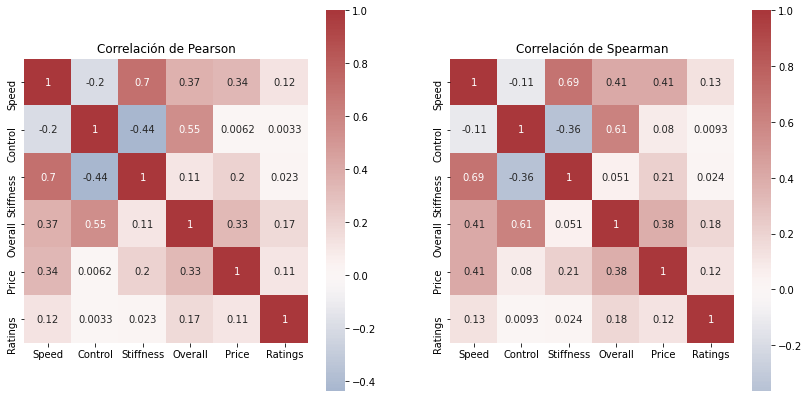

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].set_title('Correlación de Pearson')
sns.heatmap(interest_blades_df.corr(), cmap='vlag', center = 0, square=True, ax = ax[0], annot= True);
ax[1].set_title('Correlación de Spearman')
sns.heatmap(interest_blades_df.corr(method='spearman'), cmap='vlag', center = 0, square=True, ax = ax[1], annot= True);

Se observan relaciones esperadas y conocidas:

*   Correlación positiva alta entre la velocidad y la rigidez de los maderos.
*   Correlación negativa baja entre la velocidad y el control de los maderos.
*   Correlación positiva moderada entre el control y la calificación general de los maderos.

Se observan relaciones debatidas:

*   Correlación negativa moderada entre el control y la rigidez.
*   Mayor correlación entre control y calificación general que entre velocidad y calificación general.

Se observa como resultado contraintuitivo que a pesar de que el control es la característica que parece estar más fuertemente relacionada con la calificación general, esta no presenta una correlación significativa con el precio.

## ¿son estas correlaciones significativas?
Para determinar esto, se calculan los coeficientes de correlación de Pearson y Spearman para cada una de las relaciones observadas anteriormente junto con sus p-valores para determinar su significancia estadística.


In [ ]:
def correlacion_pearson_con_significancia(x, y, alfa=0.05):
  coef, p = stats.pearsonr(x, y)
  print('Coeficiente de correlación de Pearson: {:.2f}'.format(coef))
  if p > alfa:
    print('Las muestras no están correlacionadas (no rechazar H0) p={:.3f}'.format(p))
  else:
    print('Las muestras están correlacionadas (rechazar H0) p={:.3f}'.format(p))

def correlacion_spearman_con_significancia(x,y,alfa = 0.05):
  coef, p = stats.spearmanr(x, y)
  print('Coeficiente de correlación de Spearman: {:.2f}'.format(coef))
  if p > alfa:
    print('Las muestras no están correlacionadas (no rechazar H0) p={:.3f}'.format(p))
  else:
    print('Las muestras están correlacionadas (rechazar H0) p={:.3f}'.format(p))

In [ ]:
correlacion_pearson_con_significancia(interest_blades_df['Speed'], interest_blades_df['Stiffness'])
correlacion_spearman_con_significancia(interest_blades_df['Speed'], interest_blades_df['Stiffness'])

Coeficiente de correlación de Pearson: 0.70
Las muestras están correlacionadas (rechazar H0) p=0.000
Coeficiente de correlación de Spearman: 0.69
Las muestras están correlacionadas (rechazar H0) p=0.000


In [ ]:
correlacion_pearson_con_significancia(interest_blades_df['Speed'], interest_blades_df['Control'])
correlacion_spearman_con_significancia(interest_blades_df['Speed'], interest_blades_df['Control'])

Coeficiente de correlación de Pearson: -0.20
Las muestras están correlacionadas (rechazar H0) p=0.000
Coeficiente de correlación de Spearman: -0.11
Las muestras están correlacionadas (rechazar H0) p=0.035


In [ ]:
correlacion_pearson_con_significancia(interest_blades_df['Control'], interest_blades_df['Overall'])
correlacion_spearman_con_significancia(interest_blades_df['Control'], interest_blades_df['Overall'])

Coeficiente de correlación de Pearson: 0.55
Las muestras están correlacionadas (rechazar H0) p=0.000
Coeficiente de correlación de Spearman: 0.61
Las muestras están correlacionadas (rechazar H0) p=0.000


In [ ]:
correlacion_pearson_con_significancia(interest_blades_df['Control'], interest_blades_df['Stiffness'])
correlacion_spearman_con_significancia(interest_blades_df['Control'], interest_blades_df['Stiffness'])

Coeficiente de correlación de Pearson: -0.44
Las muestras están correlacionadas (rechazar H0) p=0.000
Coeficiente de correlación de Spearman: -0.36
Las muestras están correlacionadas (rechazar H0) p=0.000


In [ ]:
correlacion_pearson_con_significancia(interest_blades_df['Speed'], interest_blades_df['Overall'])
correlacion_spearman_con_significancia(interest_blades_df['Speed'], interest_blades_df['Overall'])

Coeficiente de correlación de Pearson: 0.37
Las muestras están correlacionadas (rechazar H0) p=0.000
Coeficiente de correlación de Spearman: 0.41
Las muestras están correlacionadas (rechazar H0) p=0.000


In [ ]:
correlacion_pearson_con_significancia(interest_blades_df['Price'], interest_blades_df['Control'])
correlacion_spearman_con_significancia(interest_blades_df['Price'], interest_blades_df['Control'])

Coeficiente de correlación de Pearson: 0.01
Las muestras no están correlacionadas (no rechazar H0) p=0.908
Coeficiente de correlación de Spearman: 0.08
Las muestras no están correlacionadas (no rechazar H0) p=0.138


Al verificar los p-valores que determinan la significancia de las correlaciones de Pearson y de Spearman de interés observadas, se confirma que todas son estadísticamente significativas.

# ¿Cuáles son los mejores maderos?
Decidir cuáles son los mejores maderos es un problema multiobjetivo, queremos maximizar la velocidad y el control de la raqueta a la vez que queremos minimizar su precio. Para esto tomaremos como conjunto de interés las maderas que forman parte del frente de Pareto en cuanto a estas tres variables.

In [ ]:
def find_pareto_front(df):
  pareto_df = df.copy()
  pareto_df['Front'] = True
  pareto_np = pareto_df.to_numpy();
  for i in range(0,len(pareto_np)):
    if pareto_np[i,8]:
      for j in range(0,len(pareto_np)):
        if pareto_np[j,8]:
          if (
              (pareto_np[i,1]>=pareto_np[j,1] and pareto_np[i,2]>=pareto_np[j,2] and pareto_np[i,5]<=pareto_np[j,5]) and
              (pareto_np[i,1]> pareto_np[j,1] or  pareto_np[i,2]> pareto_np[j,2] or  pareto_np[i,5]< pareto_np[j,5])
              ):
            pareto_np[j,8] = False
          elif ((pareto_np[i,1]>=pareto_np[j,1] and pareto_np[i,2]>=pareto_np[j,2] and pareto_np[i,5]<=pareto_np[j,6]) and
                (pareto_np[i,1]>pareto_np[j,1]  or  pareto_np[i,2]> pareto_np[j,2] or  pareto_np[i,5]< pareto_np[j,6])):
            pareto_np[i,8] = False
            break
  pareto_df['Front'] = pareto_np[:,8]
  pareto_df = pareto_df[pareto_df['Front']]
  pareto_df = pareto_df[['Brand', 'Name', 'Speed', 'Control', 'Price','Ratings']]
  return pareto_df

In [ ]:
pareto_df = find_pareto_front(interest_blades_df)
pareto_df

,Brand,Name,Speed,Control,Price,Ratings
184,Andro,Treiber CO OFF,9.5,9.6,318750,14
679,Donic,Appelgren World Champion 89,8.3,9.7,420000,10
872,DHS,Hurricane Long 5,9.7,9.3,712500,62
1023,Yinhe,988,9.3,8.8,75000,10
1101,Yinhe,N9S,9.0,9.5,56250,21
1124,Yinhe,T-11,9.5,8.9,93750,54
1128,Yinhe,T-4,9.6,8.3,131250,20
1129,Yinhe,T-4s,9.6,8.8,217500,16
1134,Yinhe,T-8S,9.5,9.2,225000,19
1169,Yinhe,Y-2,9.1,9.2,56250,12


In [ ]:
px.scatter_3d(pareto_df, x='Speed', y='Control', z='Price', color='Brand', hover_name="Name" , hover_data= ["Brand"], size = "Ratings", size_max=62, width=800, height=600)

Ahora vemos cómo cambia el frente de Pareto si cambiamos el número mínimo de reseñas requerido para considerar el madero como relevante.
## Con 5 o más reseñas

In [ ]:
blades_r5_df = preprocess(blades_df,5)
blades_r5_df.describe()

,Speed,Control,Stiffness,Overall,Price,Ratings
count,680.000000,680.000000,680.000000,680.000000,6.800000e+02,680.000000
mean,8.521324,8.724559,5.565294,9.014706,3.204816e+05,14.810294
std,0.930549,0.626701,1.427977,0.462103,2.328658e+05,14.752476
min,4.300000,5.700000,0.800000,7.300000,3.750000e+04,5.000000
25%,8.100000,8.400000,4.700000,8.775000,1.687500e+05,7.000000
50%,8.800000,8.800000,5.500000,9.100000,2.437500e+05,10.000000
75%,9.200000,9.200000,6.500000,9.400000,4.125000e+05,16.000000
max,9.700000,10.000000,10.000000,10.000000,1.875000e+06,132.000000


In [ ]:
pareto_5_df = find_pareto_front(blades_r5_df)
pareto_5_df

,Brand,Name,Speed,Control,Price,Ratings
184,Andro,Treiber CO OFF,9.5,9.6,318750,14
214,Ariex,Grampus Wisdom,9.6,10.0,356250,5
980,Friendship/729,Dynasty Super Carbon,9.7,7.1,120000,8
1018,Yinhe,983,9.5,6.3,78750,6
1023,Yinhe,988,9.3,8.8,75000,10
1086,Yinhe,Mercury Y-16,9.6,9.5,101250,6
1101,Yinhe,N9S,9.0,9.5,56250,21
1124,Yinhe,T-11,9.5,8.9,93750,54
1149,Yinhe,Uranus U-3,9.3,9.6,112500,9
1169,Yinhe,Y-2,9.1,9.2,56250,12


In [ ]:
px.scatter_3d(pareto_5_df, x='Speed', y='Control', z='Price', color='Brand', hover_name="Name" , hover_data= ["Brand"], size = "Ratings", size_max = 54, width=800, height=600)

## Con 20 o más reseñas

In [ ]:
blades_r20_df = preprocess(blades_df,20)
blades_r20_df.describe()

,Speed,Control,Stiffness,Overall,Price,Ratings
count,132.000000,132.000000,132.000000,132.000000,1.320000e+02,132.000000
mean,8.731818,8.817424,5.614394,9.193182,3.980682e+05,37.310606
std,0.776400,0.537523,1.356023,0.317479,2.980094e+05,20.834181
min,5.500000,7.100000,2.800000,7.700000,4.500000e+04,20.000000
25%,8.375000,8.600000,4.775000,9.000000,1.875000e+05,22.000000
50%,8.900000,8.900000,5.400000,9.300000,2.887500e+05,30.000000
75%,9.300000,9.200000,6.500000,9.400000,5.521875e+05,43.000000
max,9.700000,9.600000,9.000000,9.600000,1.548750e+06,132.000000


In [ ]:
pareto_20_df = find_pareto_front(blades_r20_df)
pareto_20_df

,Brand,Name,Speed,Control,Price,Ratings
170,Andro,Temper Tech OFF+,9.5,9.2,232500,30
193,Andro,Treiber Z,9.3,9.4,468750,57
196,Andro,Wanokiwami AO OFF,8.8,9.6,562500,21
851,DHS,Hurricane 301,9.2,9.5,258750,59
872,DHS,Hurricane Long 5,9.7,9.3,712500,62
1098,Yinhe,N-9,9.1,9.1,56250,61
1101,Yinhe,N9S,9.0,9.5,56250,21
1124,Yinhe,T-11,9.5,8.9,93750,54
1128,Yinhe,T-4,9.6,8.3,131250,20
1277,Huaruite,Clipper,8.3,9.2,45000,22


In [ ]:
px.scatter_3d(pareto_20_df, x='Speed', y='Control', z='Price', color='Brand', hover_name="Name" , hover_data= ["Brand"], size = "Ratings", size_max = 62, width=800, height=600)


## Con 30 o más reseñas

In [ ]:
blades_r30_df = preprocess(blades_df,30)
blades_r30_df.describe()

,Speed,Control,Stiffness,Overall,Price,Ratings
count,69.000000,69.000000,69.000000,69.000000,6.900000e+01,69.000000
mean,8.823188,8.827536,5.694203,9.243478,4.210870e+05,50.115942
std,0.686240,0.531614,1.325639,0.275723,3.058060e+05,21.924695
min,6.700000,7.100000,3.100000,8.600000,5.625000e+04,30.000000
25%,8.500000,8.600000,4.800000,9.100000,1.875000e+05,34.000000
50%,9.000000,8.900000,5.500000,9.300000,3.562500e+05,43.000000
75%,9.400000,9.200000,6.500000,9.500000,5.625000e+05,59.000000
max,9.700000,9.500000,8.800000,9.600000,1.548750e+06,132.000000


In [ ]:
pareto_30_df = find_pareto_front(blades_r30_df)
pareto_30_df

,Brand,Name,Speed,Control,Price,Ratings
168,Andro,Temper Tech ALL+,7.9,9.5,191250,42
170,Andro,Temper Tech OFF+,9.5,9.2,232500,30
193,Andro,Treiber Z,9.3,9.4,468750,57
315,Butterfly,Boll TriCarbon,9.7,7.1,431250,38
735,Donic,Ovtcharov Carbospeed,9.6,8.2,236250,33
851,DHS,Hurricane 301,9.2,9.5,258750,59
871,DHS,Hurricane Long 3,9.4,9.4,750000,34
872,DHS,Hurricane Long 5,9.7,9.3,712500,62
1098,Yinhe,N-9,9.1,9.1,56250,61
1124,Yinhe,T-11,9.5,8.9,93750,54


In [ ]:
px.scatter_3d(pareto_30_df, x='Speed', y='Control', z='Price', color='Brand', hover_name="Name" , hover_data= ["Brand"], size = "Ratings", size_max = 92, width=800, height=600)


## Con 40 o más reseñas

In [ ]:
blades_r40_df = preprocess(blades_df,40)
blades_r40_df.describe()

,Speed,Control,Stiffness,Overall,Price,Ratings
count,39.000000,39.000000,39.000000,39.000000,3.900000e+01,39.000000
mean,8.848718,8.776923,5.787179,9.225641,4.344231e+05,62.666667
std,0.630318,0.555575,1.281278,0.294438,3.098194e+05,21.912906
min,6.700000,7.100000,3.300000,8.600000,5.625000e+04,41.000000
25%,8.500000,8.600000,5.000000,9.050000,1.875000e+05,47.000000
50%,8.900000,8.900000,5.700000,9.300000,3.562500e+05,56.000000
75%,9.300000,9.100000,6.500000,9.450000,5.906250e+05,71.000000
max,9.700000,9.500000,8.500000,9.600000,1.125000e+06,132.000000


In [ ]:
pareto_40_df = find_pareto_front(blades_r40_df)
pareto_40_df

,Brand,Name,Speed,Control,Price,Ratings
168,Andro,Temper Tech ALL+,7.9,9.5,191250,42
193,Andro,Treiber Z,9.3,9.4,468750,57
851,DHS,Hurricane 301,9.2,9.5,258750,59
872,DHS,Hurricane Long 5,9.7,9.3,712500,62
1098,Yinhe,N-9,9.1,9.1,56250,61
1124,Yinhe,T-11,9.5,8.9,93750,54
2152,Tibhar,Stratus Power Wood,8.9,9.3,146250,92
2441,Yasaka,Dynamix 17,9.5,9.0,273750,51


In [ ]:
px.scatter_3d(pareto_40_df, x='Speed', y='Control', z='Price', color='Brand', hover_name="Name" , hover_data= ["Brand"], size = "Ratings", size_max = 92, width=800, height=600)

# Conclusiones
Basados en los análisis desarrollados sobre la base de datos de maderos recuperada, se llegó a los siguientes resultados y conclusiones:

*   Se elaboraron 2 visualizaciones multivariadas que permiten observar las relaciones entre las características que describen un madero de tenis de mesa que potencialmente pueden permitir a un usuario identificar con mayor rapidez y eficacia un madero de su interés comparado a la navegación tradicional por el sitio web Revspin.

*   Se determinaron y tabularon las correlaciones entre las distintas variables de los maderos de tenis de mesa teniendo en cuenta sus respectivas significancias estadísticas lo cual además de permitir cuantificar y visualizar la relación entre las variables de interés, sirve como referente para contrastar creencias sobre las mismas prevalentes en la comunidad.

*   Se determinaron varios frentes de Pareto que optimizan las características velocidad, control y precio que pueden ser llamados como los mejores dentro de los grupos correspondientes a los que pertenecen. 

# ¿Cómo pueden aprovecharse estos resultados?
Estos resultados pueden aprovecharse desde distintos ámbitos por parte de la comunidad del tenis de mesa. 
*   Desde la perspectiva de los jugadores, tener una relación más clara entre las variables que describen los maderos y la identificación de los frentes de pareto les permite tener un criterio más solido a la hora de elegir sus implementos los cuales son fundamentales en el desarrollo de la práctica.
*   Desde la perspectiva de los vendedores de elementos deportivos, identificar que maderos poseen las mejores características les permite tener una ventaja competitiva a la hora de identificar con qué grupos de productos abastecerse. Además, el mejoramiento del criterio sobre los productos también les permite dar un valor agregado a sus clientes dando recomendaciones informadas sobre los mismos.

# Trabajo futuro
A partir del desarrollo de este proyecto se vislumbran como posibles continuaciones del mismo las siguientes actividades:

*   Implementar mecanismos de actualización de los datos periódicamente que permitan que los análisis desarrollados no sean estáticos, sino que se mantengan cerca del estado actual de forma automatizada.

*   Buscar el origen de las relaciones entre las variables halladas. Por ejemplo, la relación inversa entre la velocidad y el control de los maderos era esperada. Sin embargo, resulta comparativamente pequeña lo cual puede tener distintas explicaciones. Por ejemplo, puede que los usuarios no evalúen esta variable de manera independiente, sino que la evalúen en relación a la velocidad, la frase "tiene buen control para la velocidad que tiene" la cual es bastante común permite inferir que esta calificación no es independiente como debería para un análisis más detallado.

*   Extender el análisis de elementos de tenis de mesa no solo a maderos sino también a cauchos pues estos tienen muchas más variables que determinan su calidad y las relaciones entre estos son aún menos claras que las encontradas en los maderos. Para esto se requiere la recopilación de una base de datos sobre los mismos potencialmente vía Webscrapping como fue obtenida originalmente la base de datos con la que se trabajó por parte del usuario StefPY de Kaggle.
<br>![alt text](https://www.zonatt.com/media/zonatt/image/noticias/873_Foto.1585821750.png)

*   Estandarizar la calificación de los elementos de tenis de mesa con criterios más científicos dado que variables como el control aunque son bien conocidas en la comunidad son altamente subjetivas y la comparación sobre estas parece no ser tan robusta.

*   Desarrollar sistemas de recomendación que permitan determinar a partir de los datos de un usuario que productos tienen una alta probabilidad de ser de interés de este en base a registros anteriores u otros datos de este.